In [1]:
from __future__ import print_function
import torch, os, gym, time, glob, argparse, sys
import numpy as np
from scipy.signal import lfilter
from scipy.misc import imresize # preserves single-pixel info _unlike_ img = img[::2,::2]
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Agent

In [2]:
class NNPolicy(torch.nn.Module): # an actor-critic neural network
    def __init__(self, channels, num_actions):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.lstm = nn.LSTMCell(32 * 5 * 5, 256)
        self.critic_linear, self.actor_linear = nn.Linear(256, 1), nn.Linear(256, num_actions)
        self.hx = Variable(torch.zeros(1, 256))
        self.cx = Variable(torch.zeros(1, 256))
        

    def forward(self, inputs):
        inputs = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = x.view(-1, 32 * 5 * 5)
        self.hx, self.cx = self.lstm(x, (self.hx, self.cx))
        return self.critic_linear(self.hx), self.actor_linear(self.hx)

    def try_load(self, save_dir, checkpoint='*.tar'):
        paths = glob.glob(save_dir + checkpoint) ; step = 0
        if len(paths) > 0:
            ckpts = [int(s.split('.')[-2]) for s in paths]
            ix = np.argmax(ckpts) ; step = ckpts[ix]
            self.load_state_dict(torch.load(paths[ix]))
        print("\tno saved models") if step is 0 else print("\tloaded model: {}".format(paths[ix]))
        return step
       
    
    def predict(self, X):
        res = np.zeros((X.shape[0], 4))
        for i, x in enumerate(X):
            x = imresize(x[35:195].mean(2), (80,80)).astype(np.float32).reshape(1,80,80)/255.
            x = torch.tensor(x)
            value, logit = self(x.view(1,1,80,80))
            logp = F.log_softmax(logit, dim=-1)
            res[i,:] = torch.exp(logp).data.numpy()
        return res

# Env

In [3]:
save_dir ="weights/"
env = gym.make('Breakout-v4')
np.random.seed(123)
env.seed(123)
num_actions = env.action_space.n # get the action space of this game

model = NNPolicy(channels=1, num_actions=num_actions)
model.try_load(save_dir)
state = env.reset()

	loaded model: weights\strong.40.tar


## Test

C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


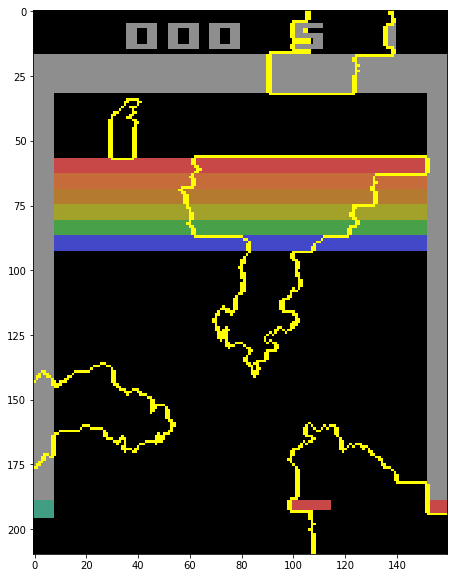

In [4]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

state = env.reset()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(state, model.predict, top_labels=4, hide_color=0, num_samples=1000)
action = np.argmax(model.predict(np.expand_dims(state, axis=0))[0])
temp, mask = explanation.get_image_and_mask(action, positive_only=True, num_features=10, hide_rest=False)
plt.figure(figsize=(10,10))
plt.imshow(mark_boundaries(temp /255, mask))

from IPython import display
current_state = env.reset()
img = plt.imshow(current_state)
for i in tqdm(range(1000)):
    x = np.expand_dims(current_state, axis=0)
    action = np.argmax(model.predict(x)[0])
    current_state, reward, done, _ = env.step(action)
    img.set_data(current_state)
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Boucle

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
 90%|█████████ | 452/500 [05:03<51:39, 64.57s/it]C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
 91%|█████████ | 453/500 [09:30<1:38:16, 125.46s/it]C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
 91%|█████████ | 454/500 [14:03<2:09:56, 169.49s/it]C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: Depreca

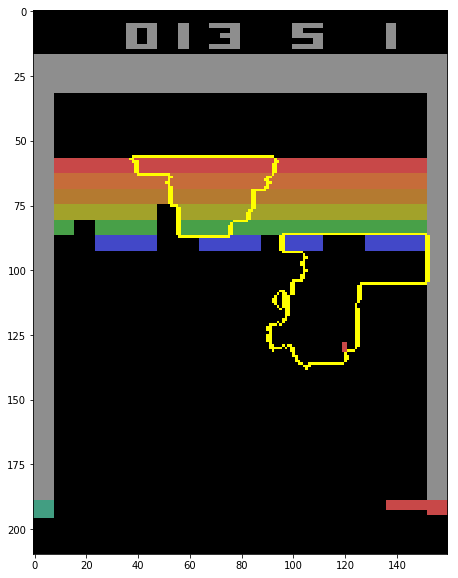

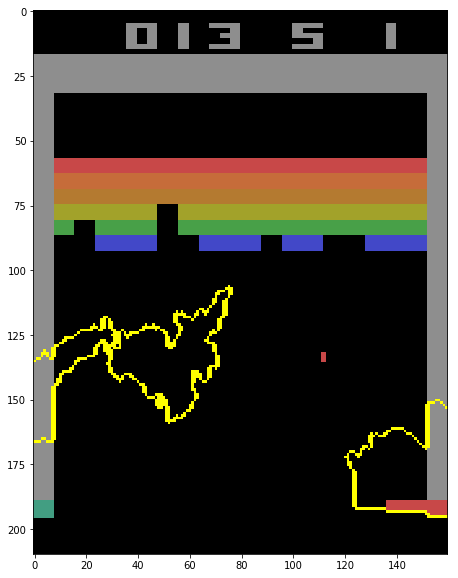

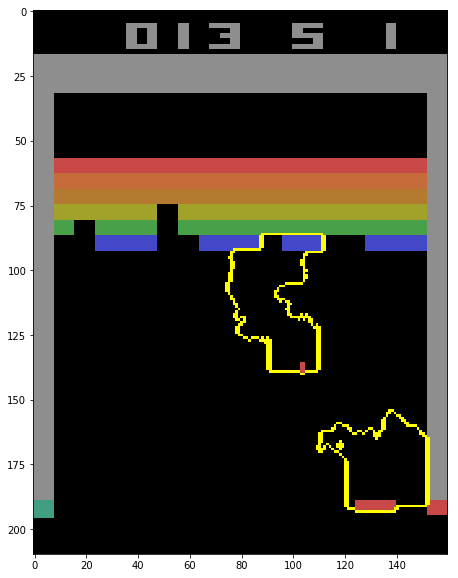

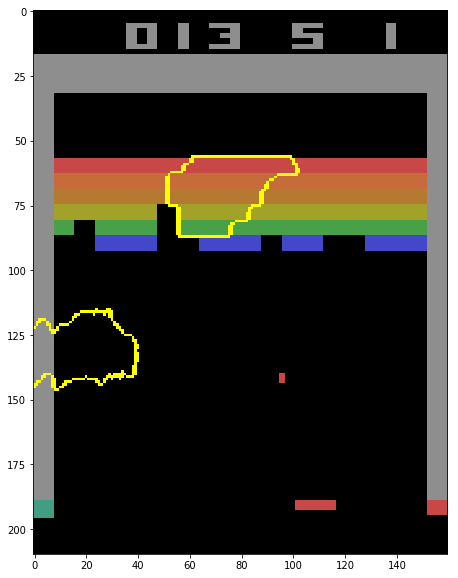

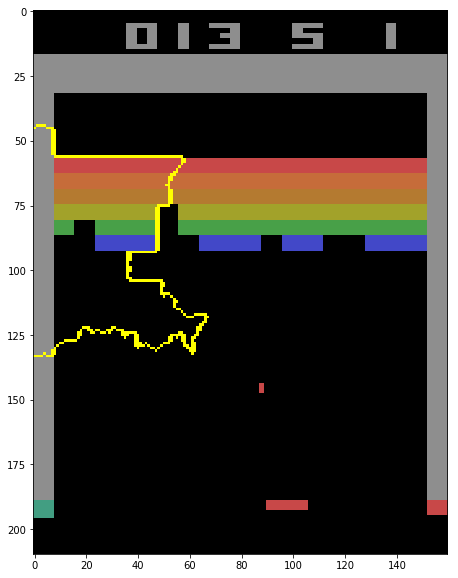

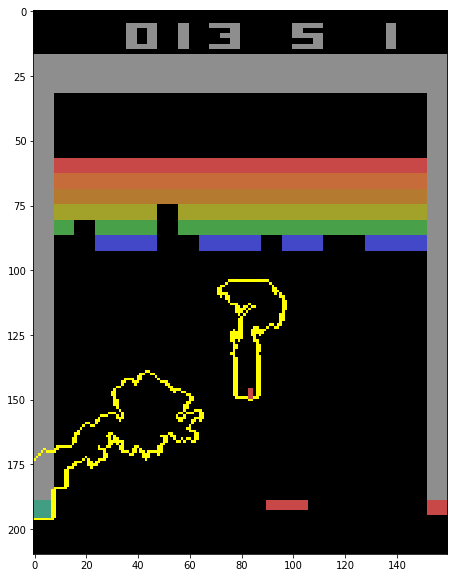

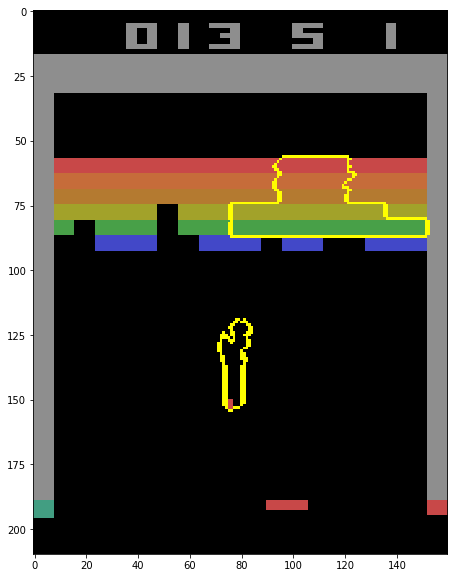

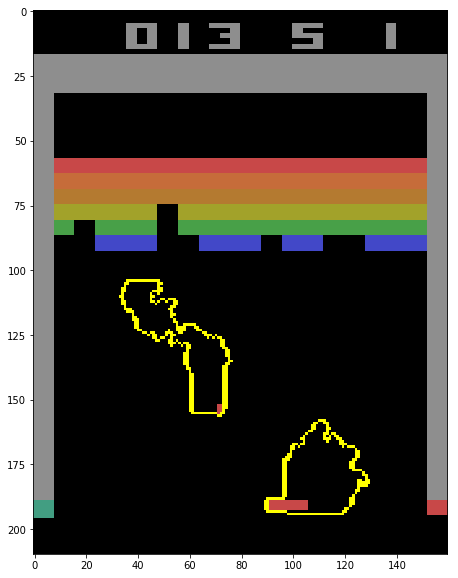

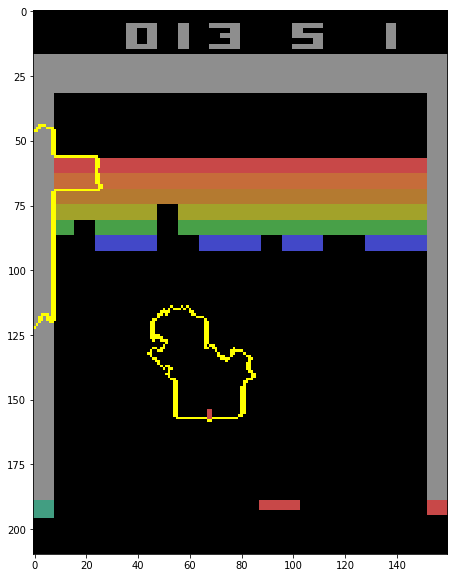

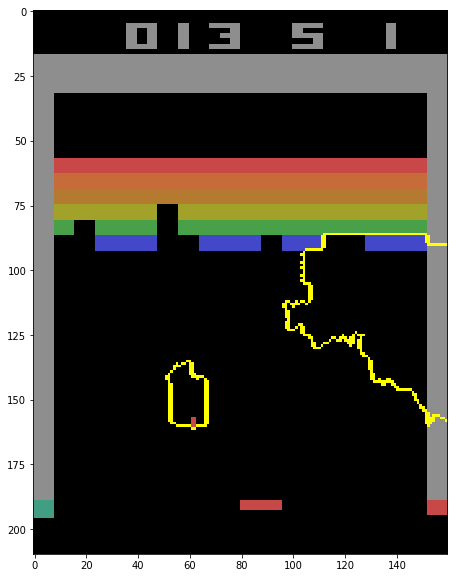

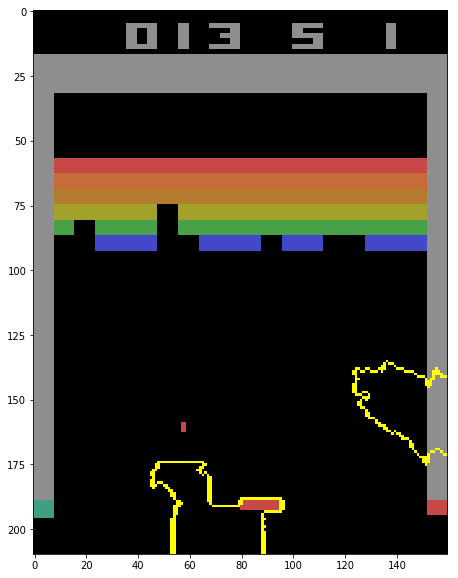

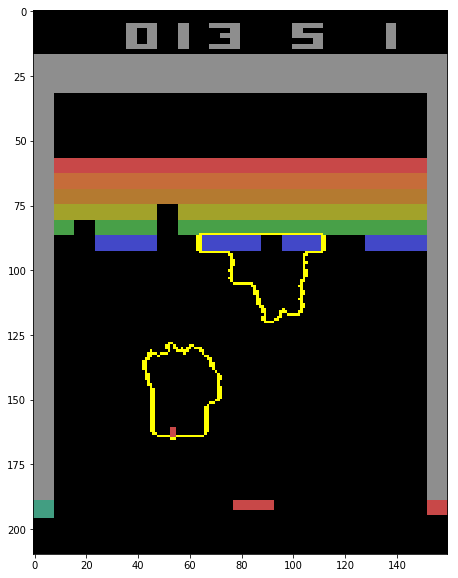

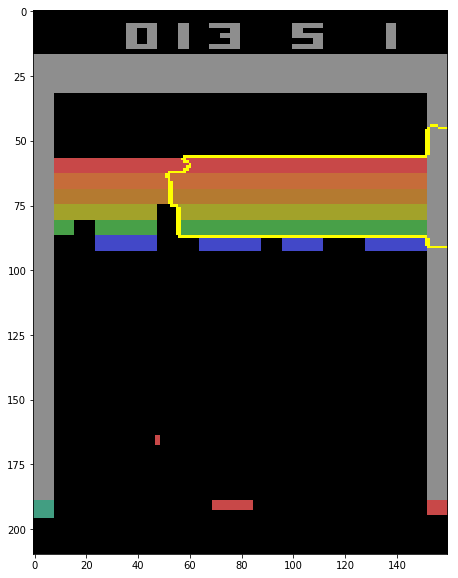

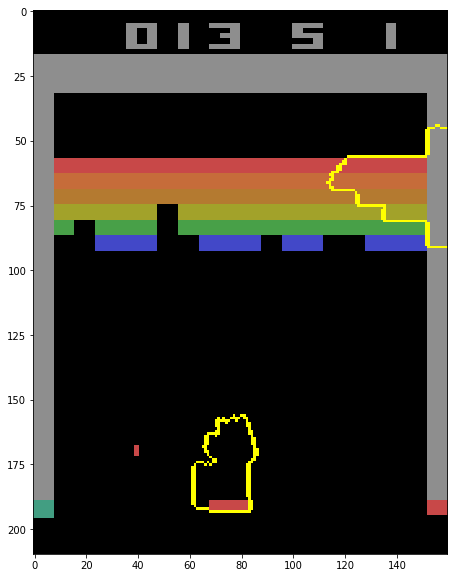

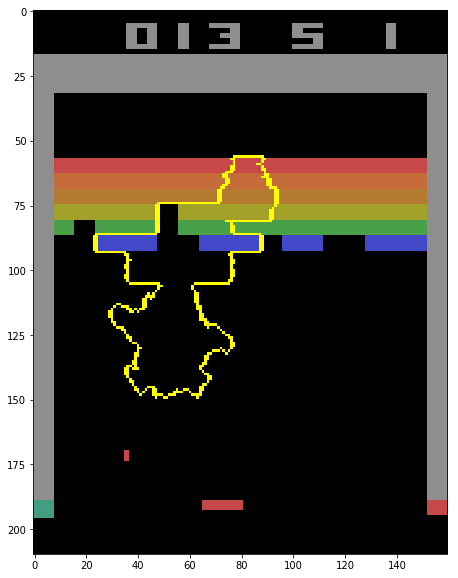

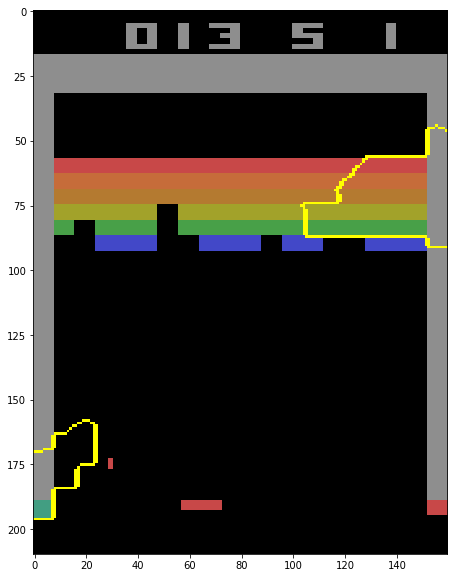

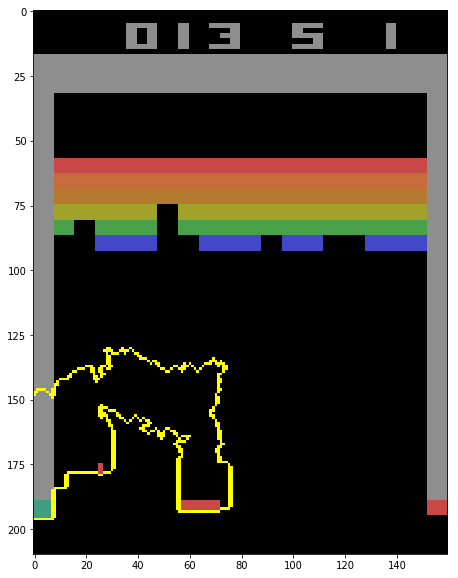

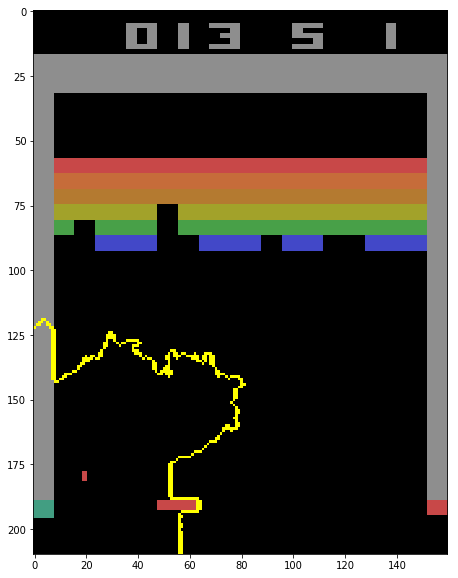

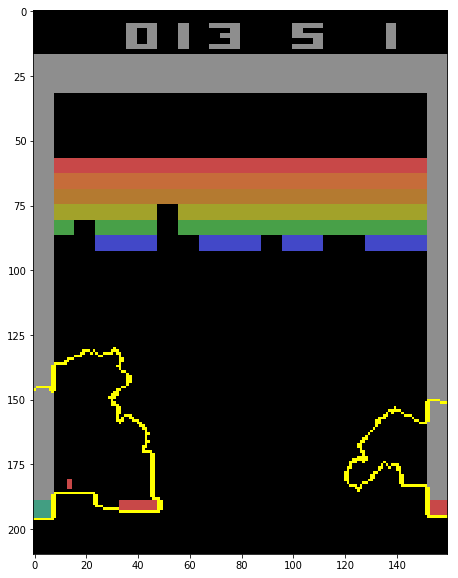

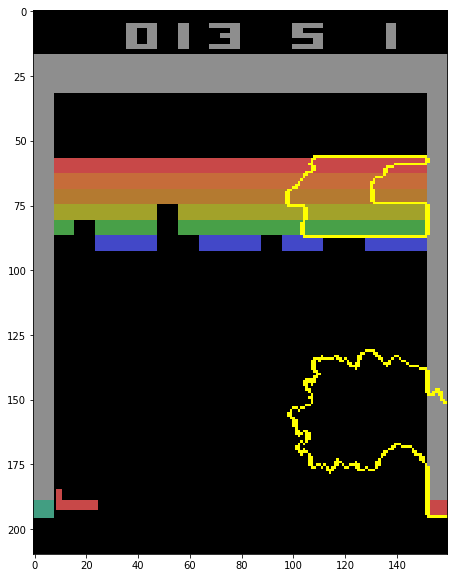

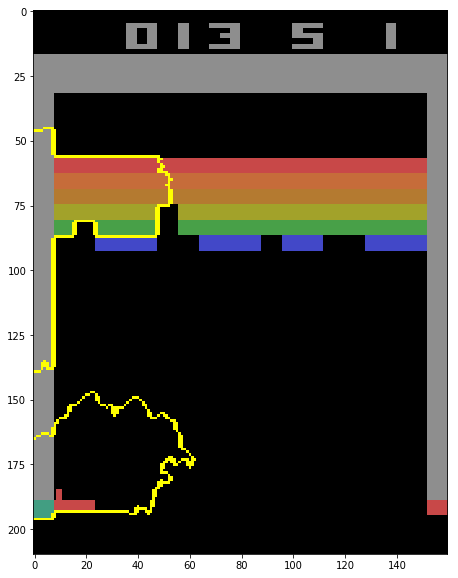

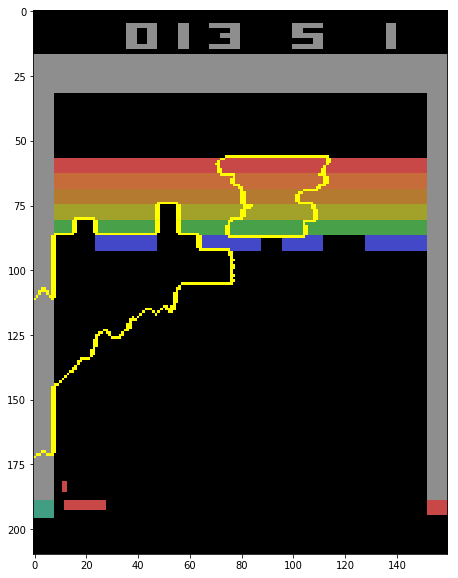

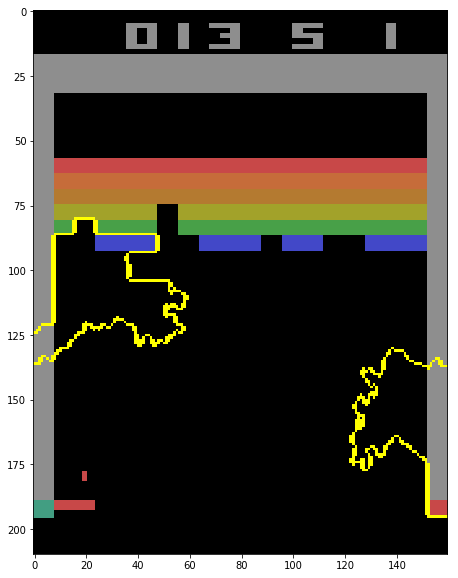

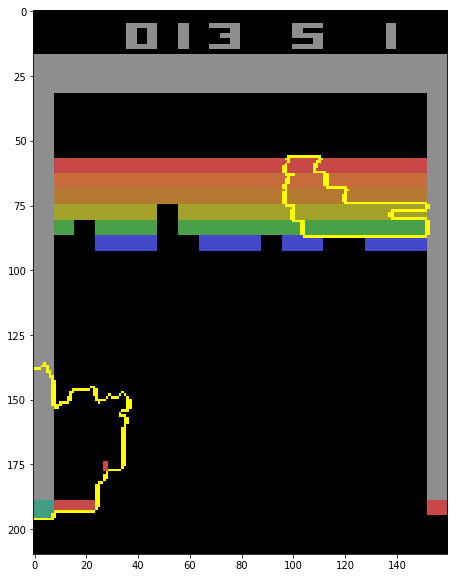

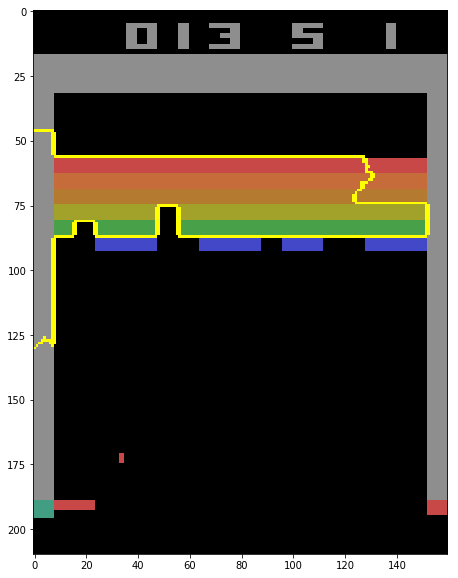

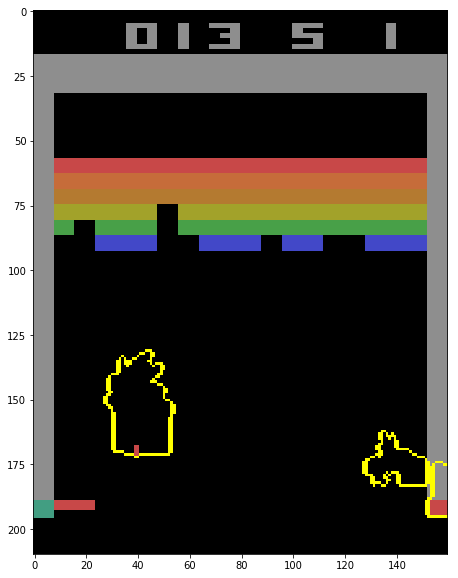

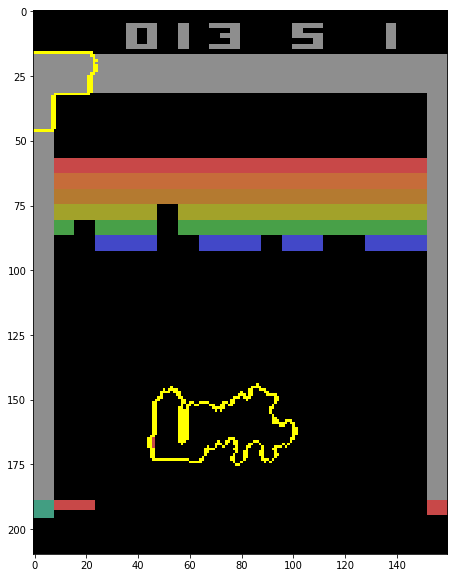

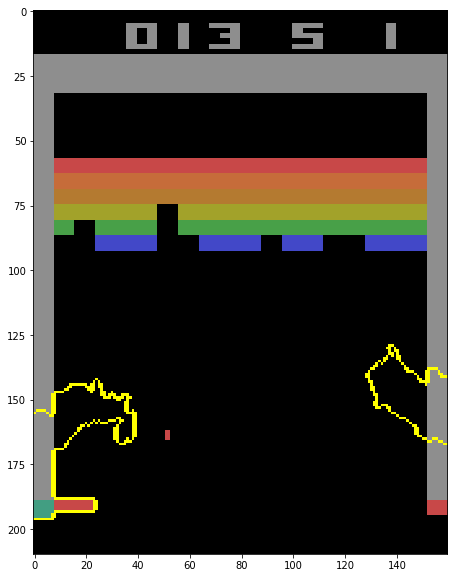

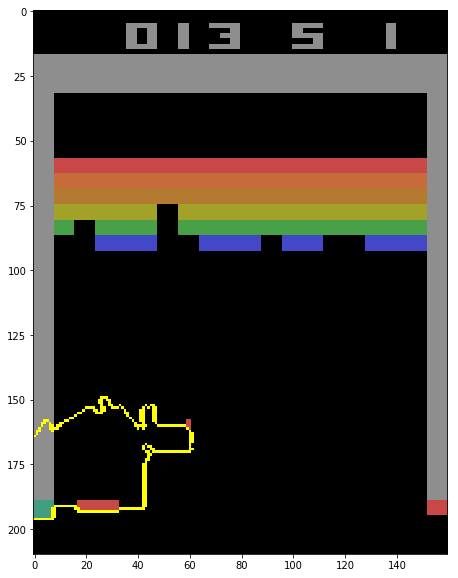

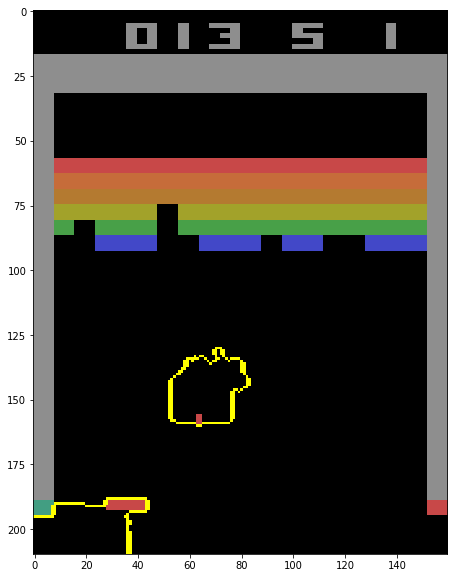

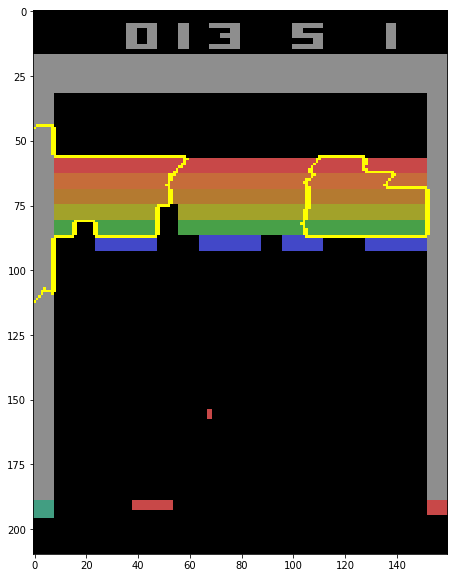

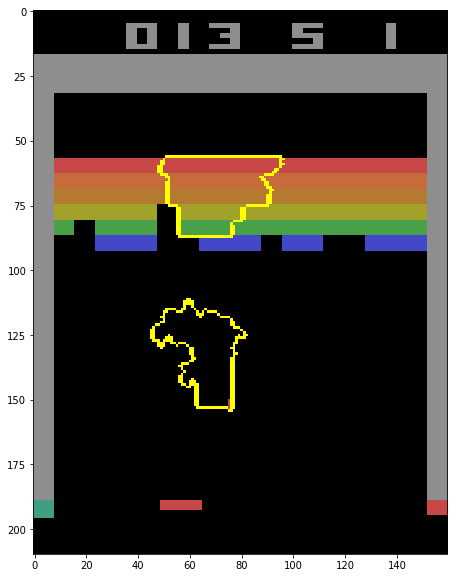

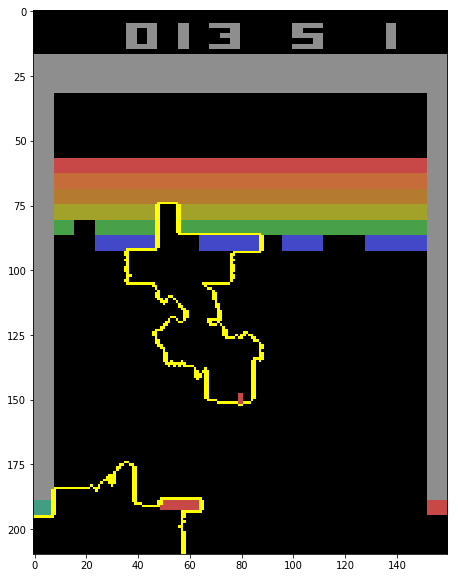

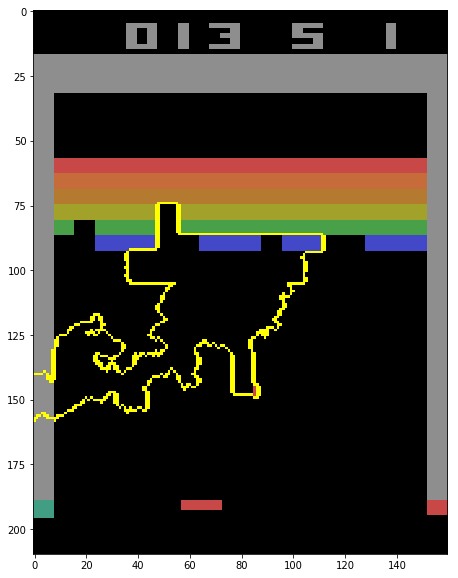

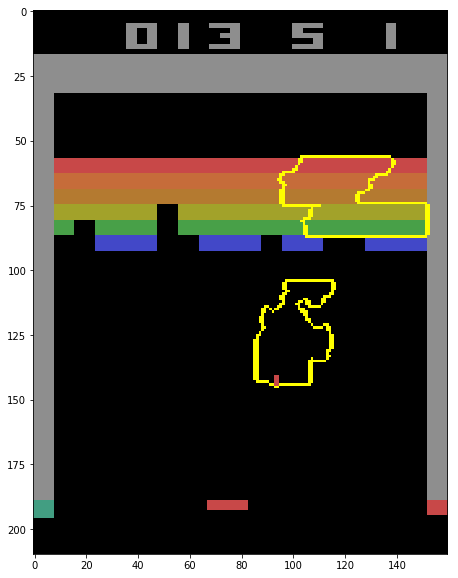

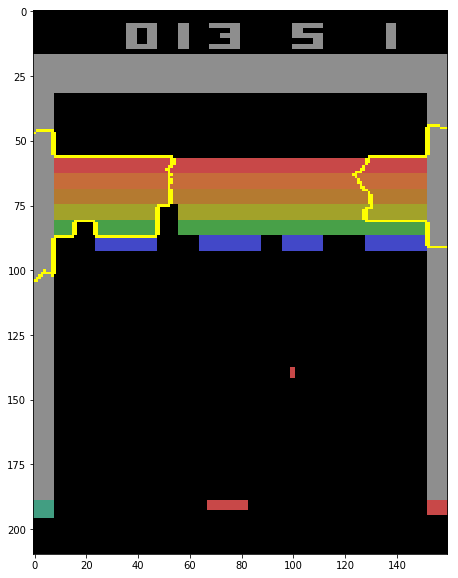

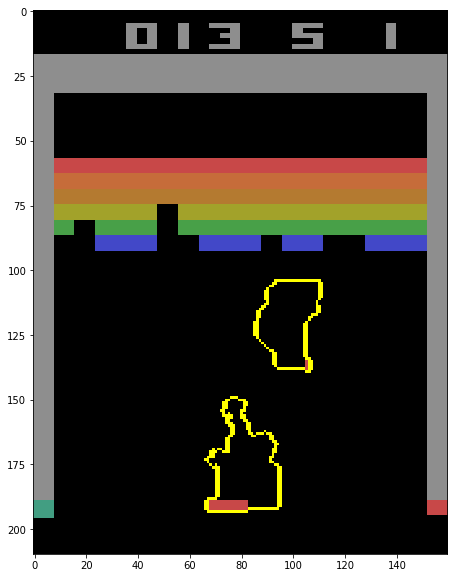

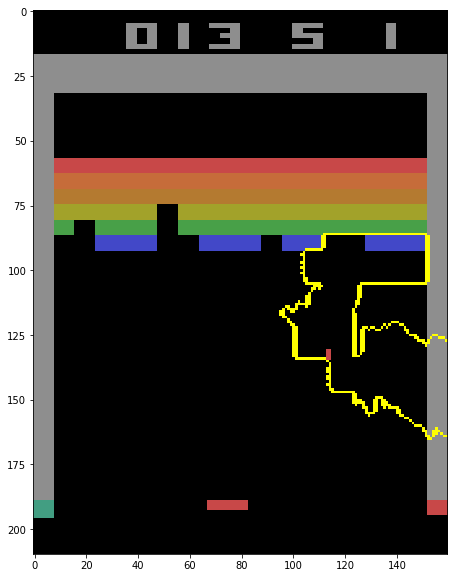

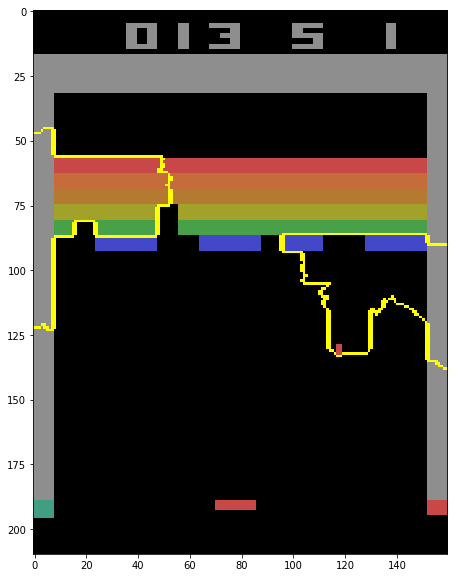

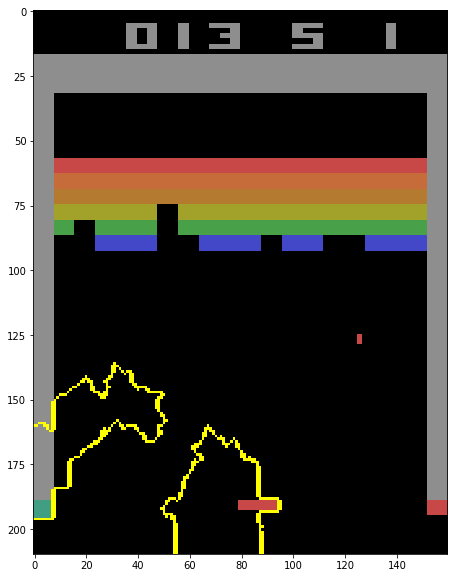

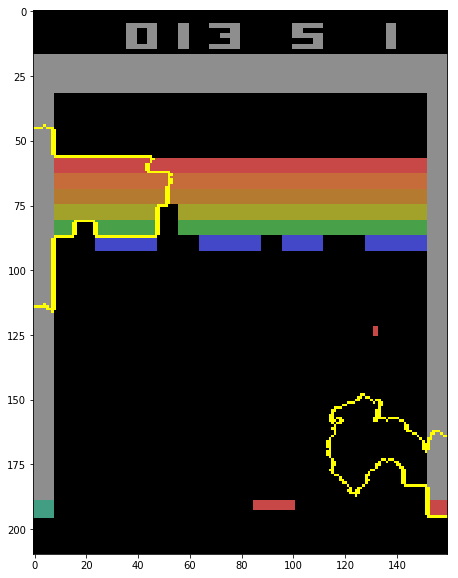

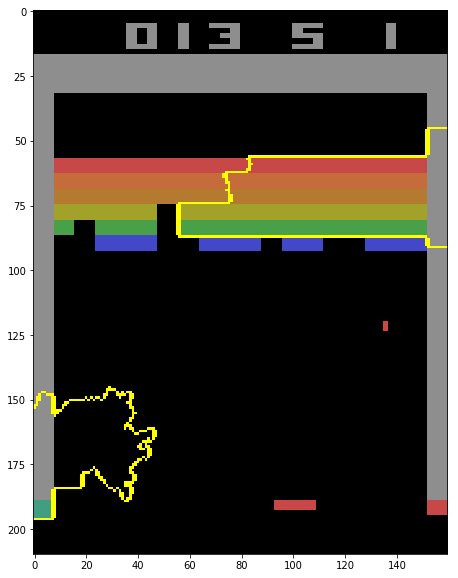

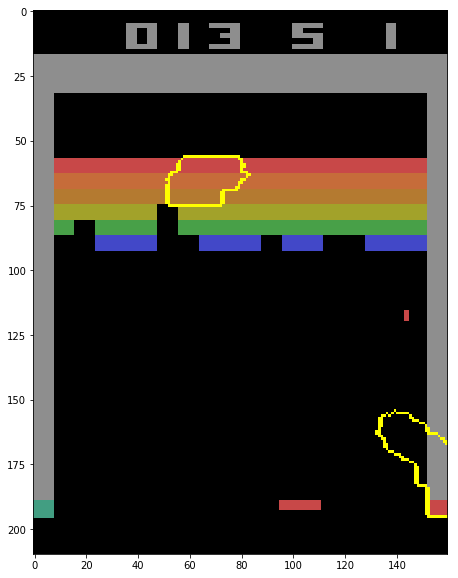

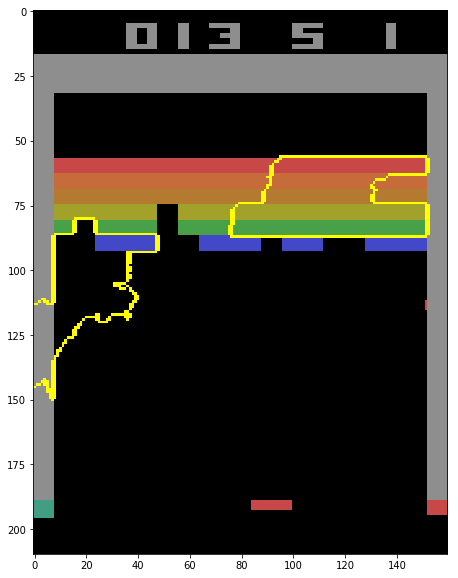

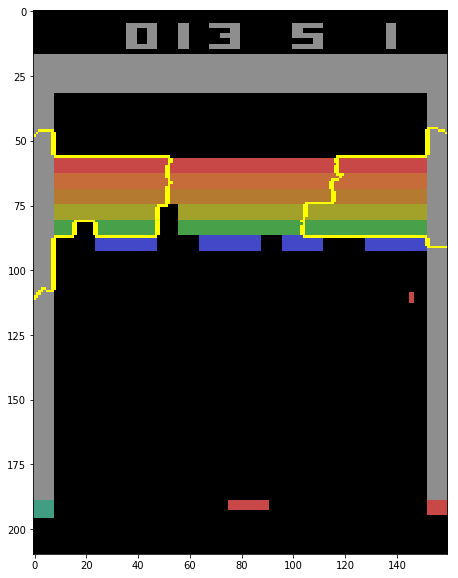

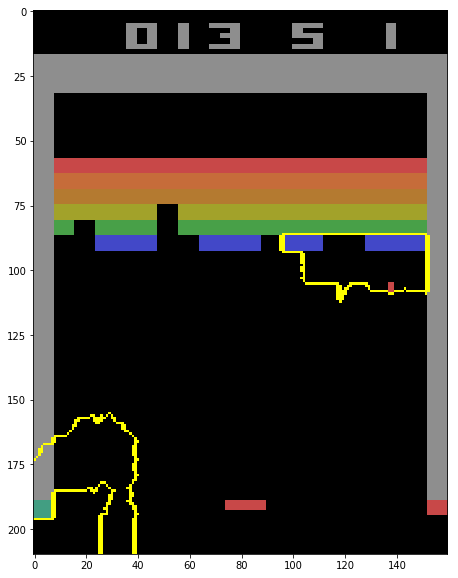

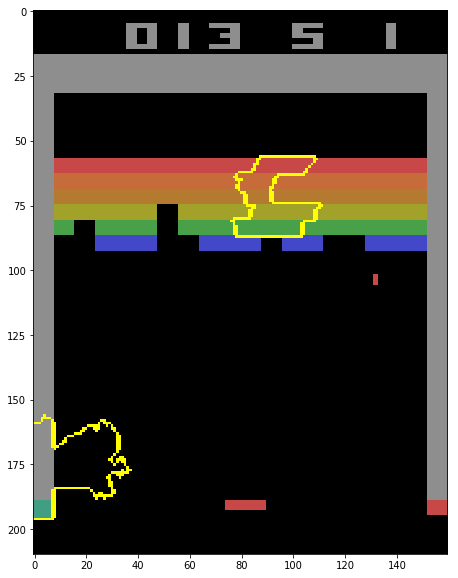

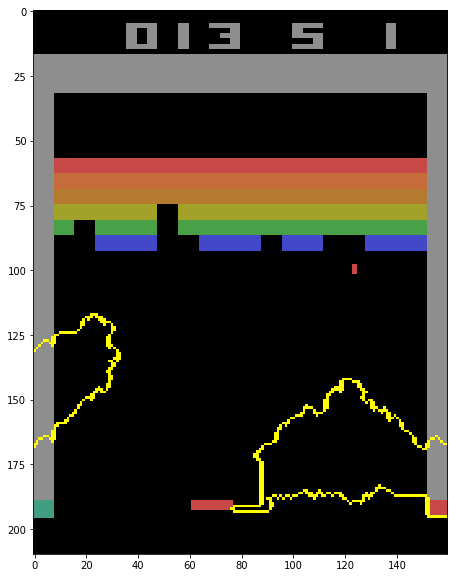

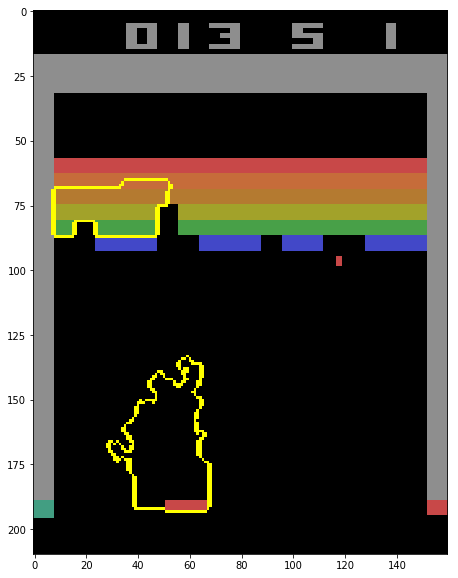

In [6]:
current_state = env.reset()
for i in tqdm(range(500)):
    x = np.expand_dims(current_state, axis=0)
    action = np.argmax(model.predict(x)[0])
    if i > 450:
        explanation = explainer.explain_instance(current_state, model.predict, top_labels=4, hide_color=0, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(action, positive_only=True, num_features=2, hide_rest=False)
        plt.figure(figsize=(10,10))
        plt.imshow(mark_boundaries(temp /255, mask))
    current_state, reward, done, _ = env.step(action)
    
    
    #env.render()

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
 85%|████████▌ | 341/400 [00:01<00:00, 320.45it/s]C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
 88%|████████▊ | 354/400 [00:27<00:28,  1.64it/s] C:\Users\User\Anaconda3\envs\RL_vizu\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is 

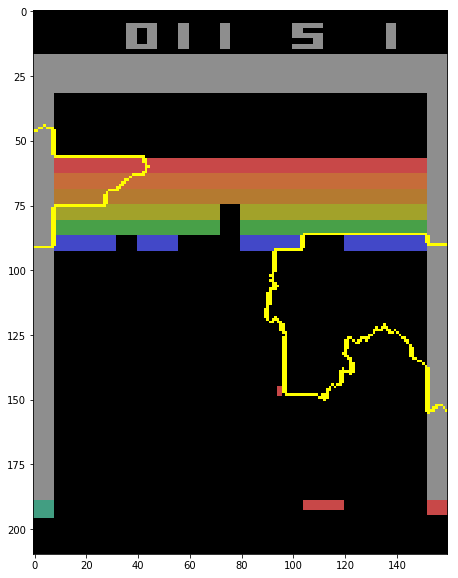

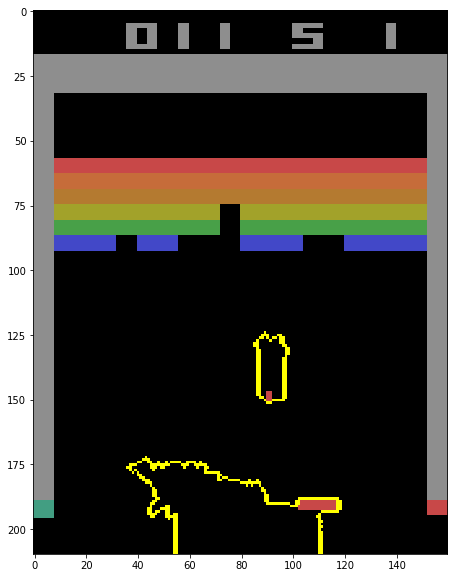

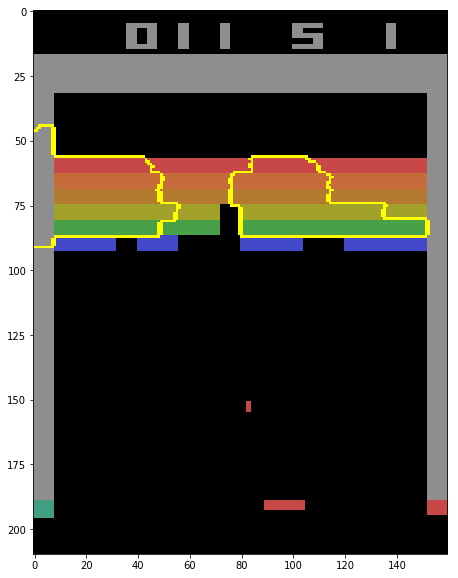

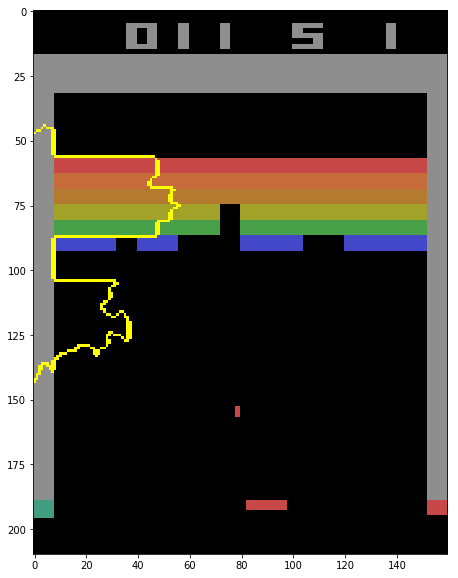

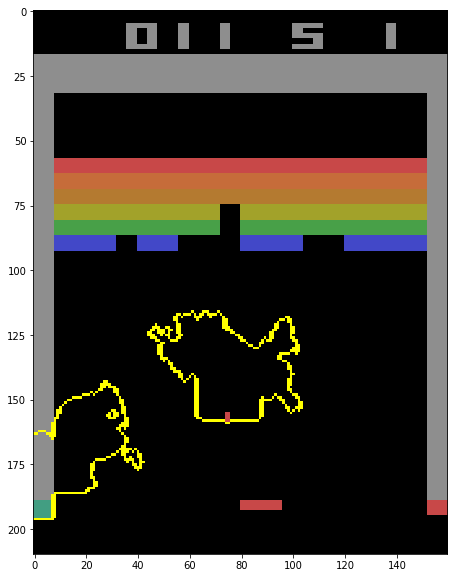

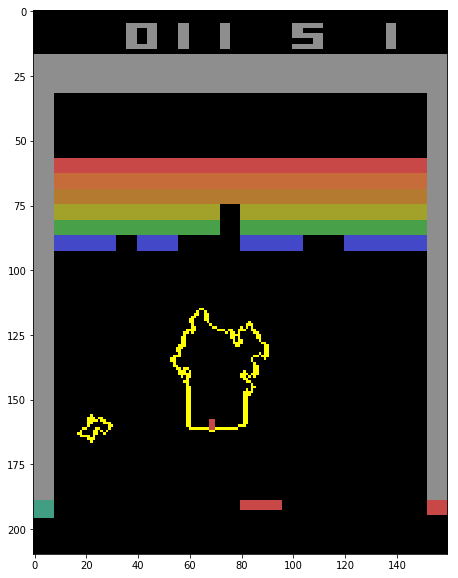

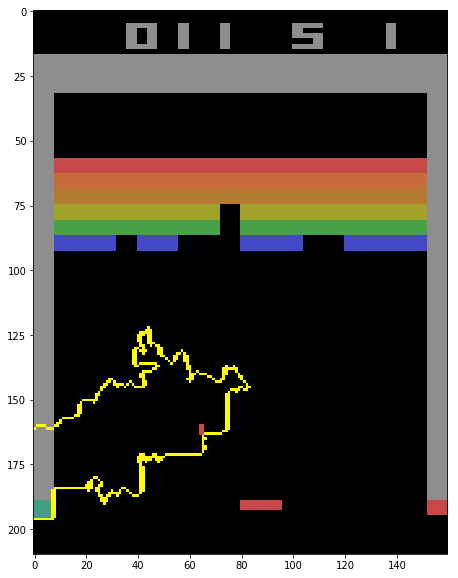

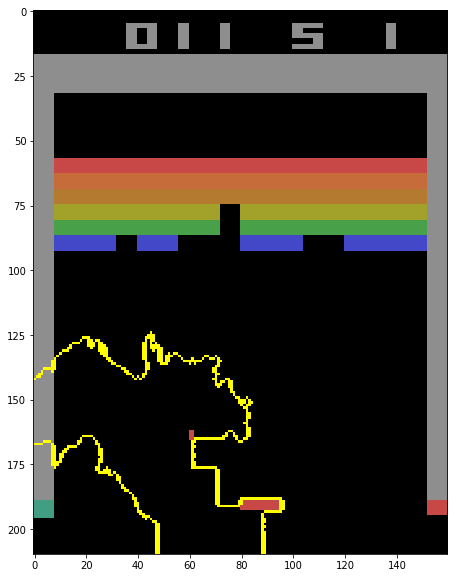

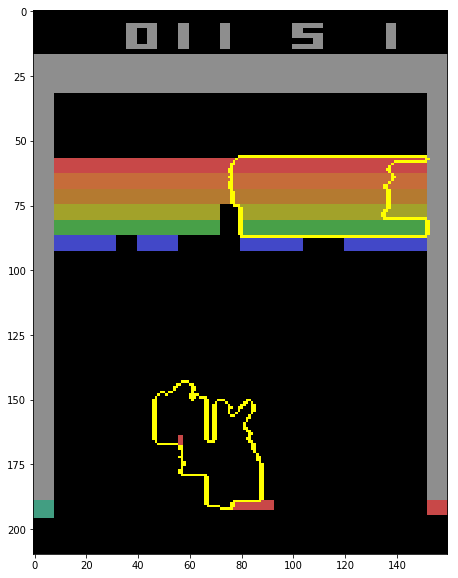

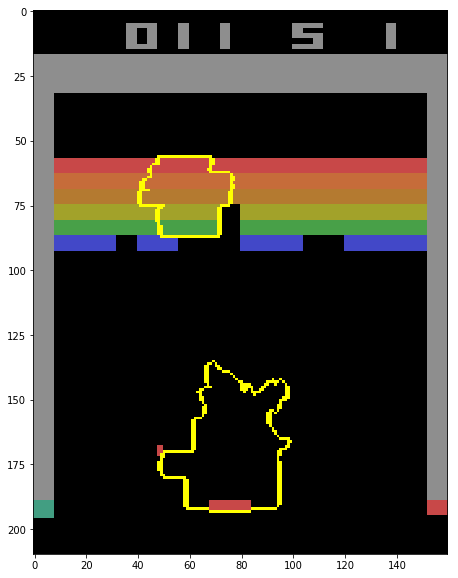

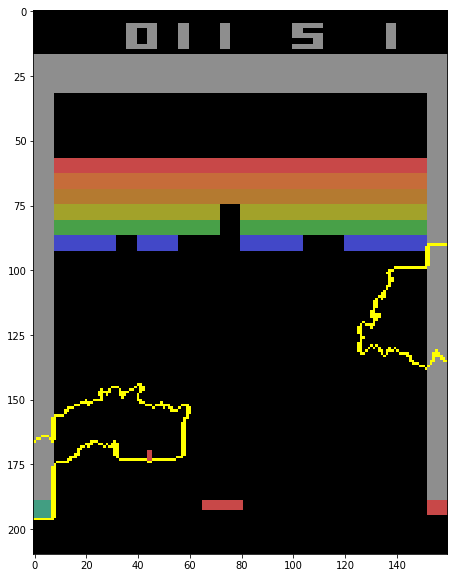

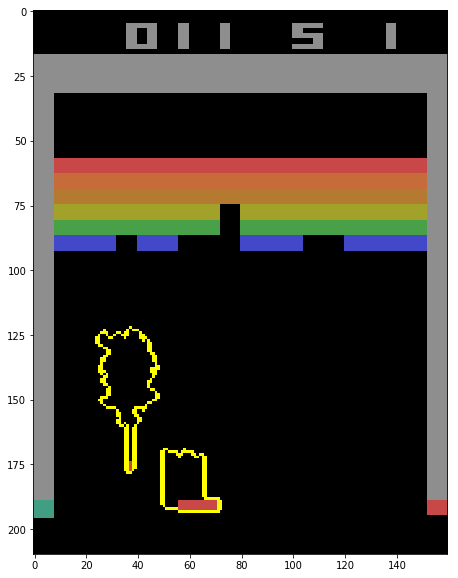

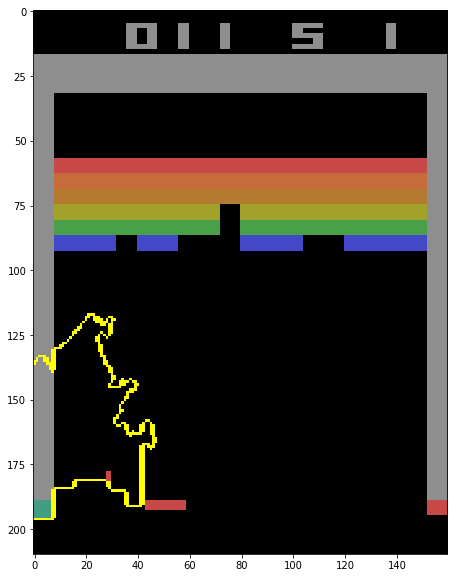

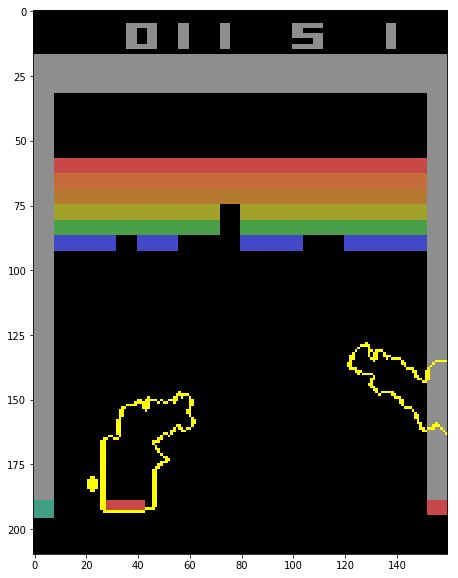

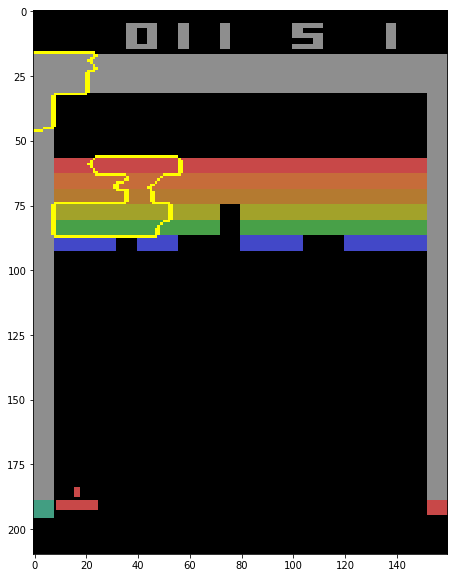

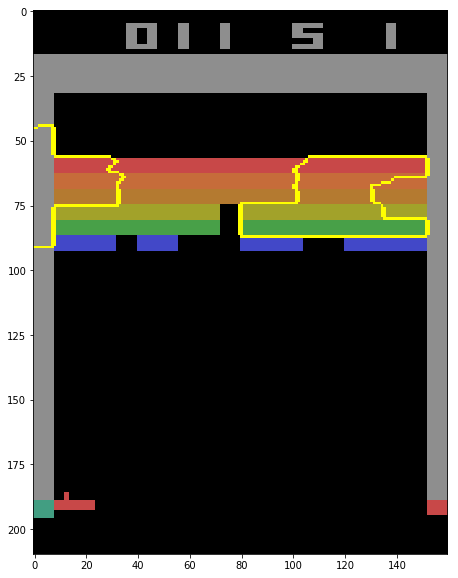

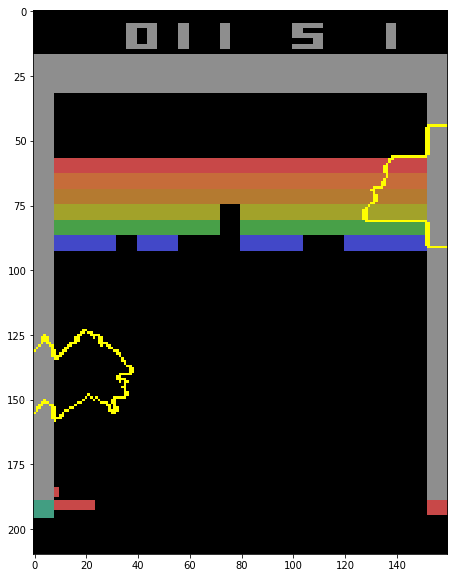

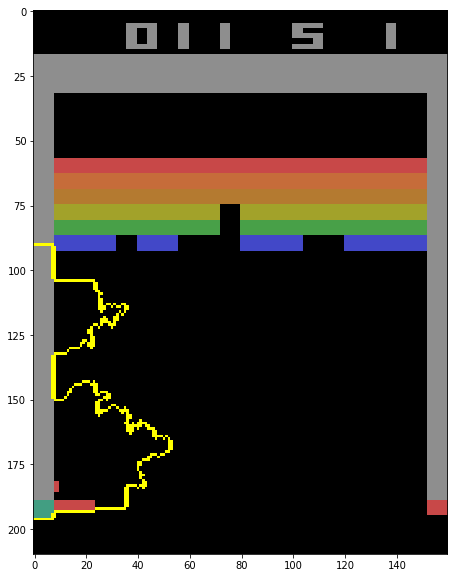

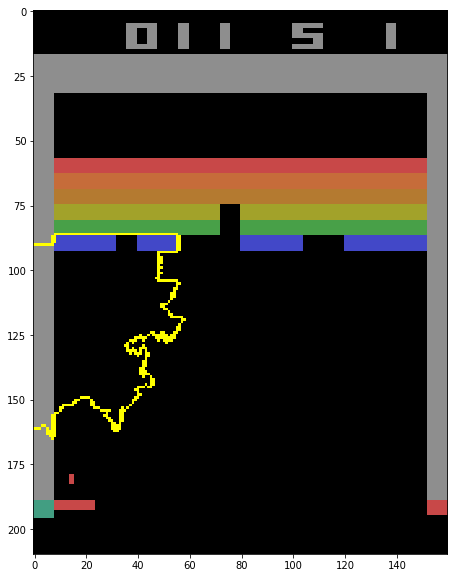

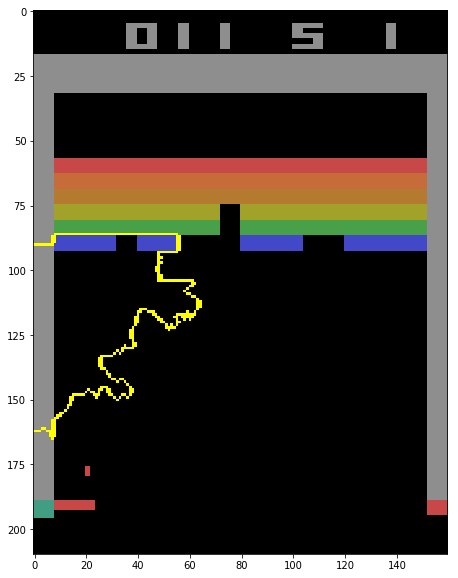

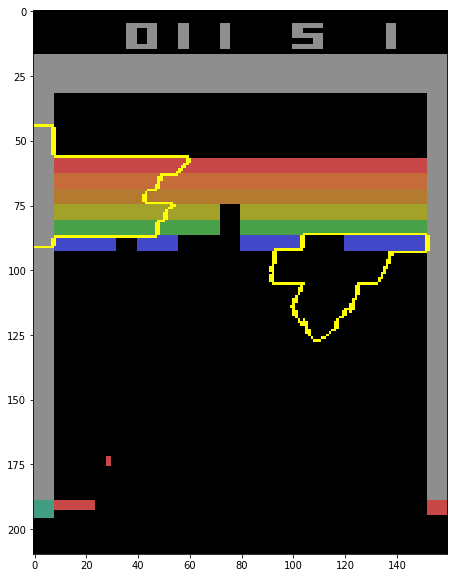

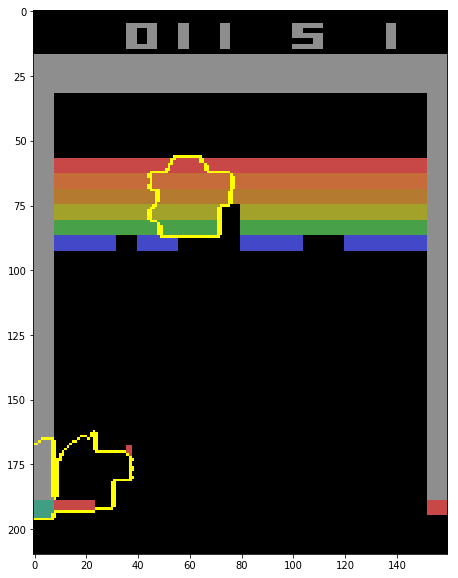

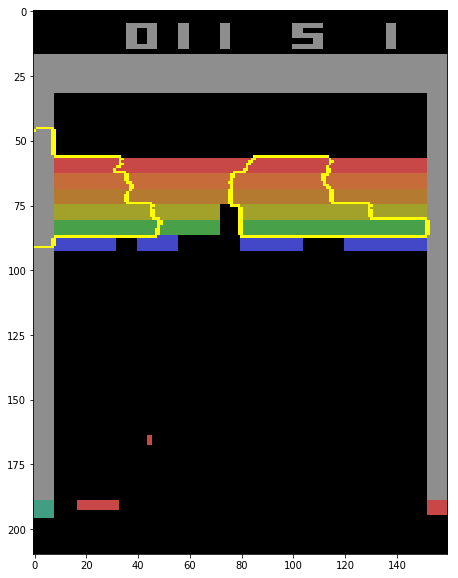

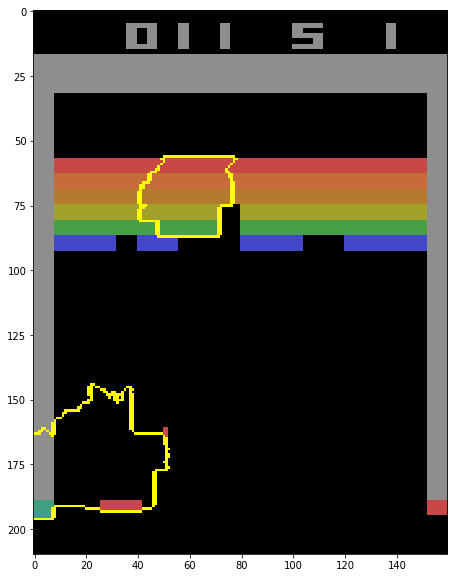

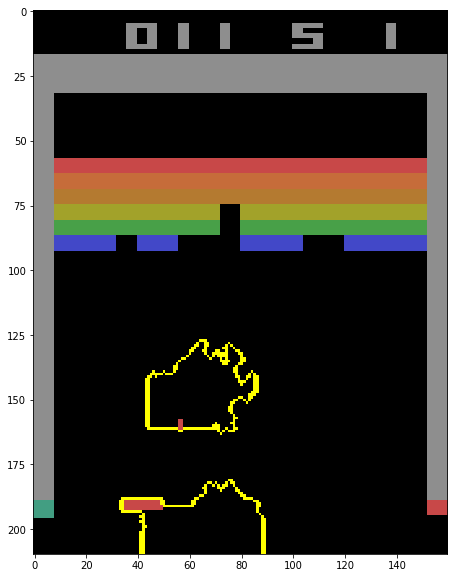

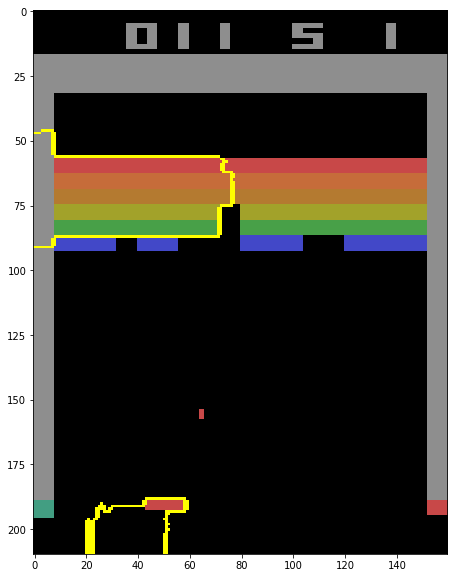

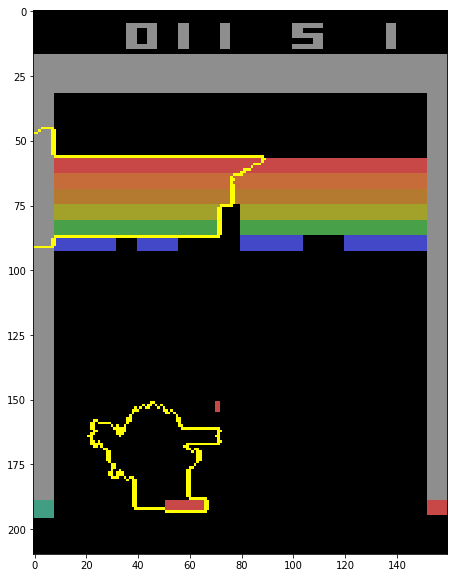

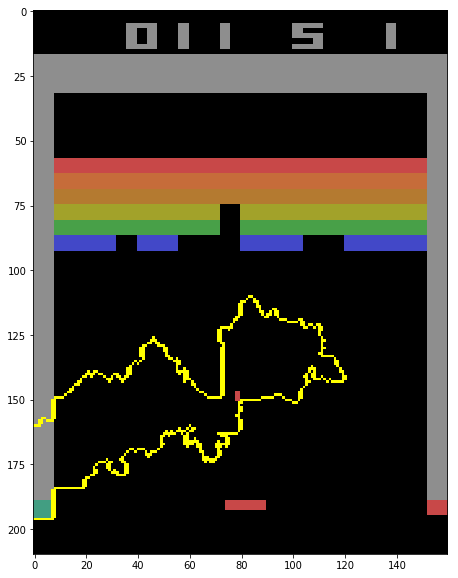

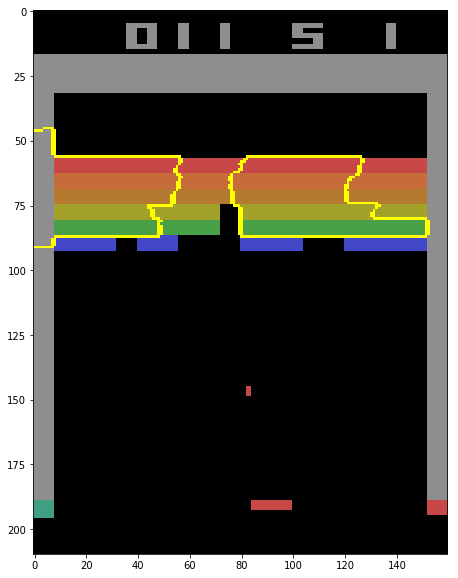

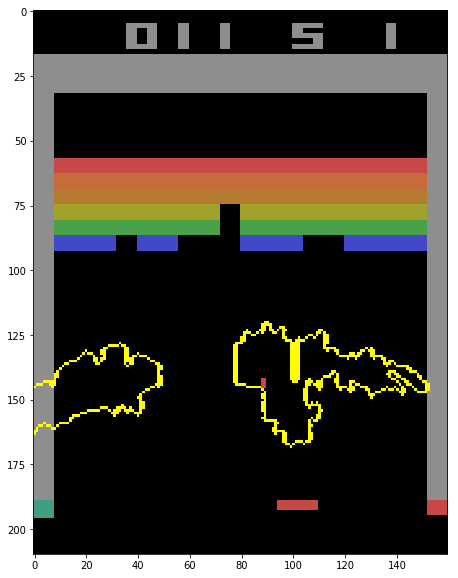

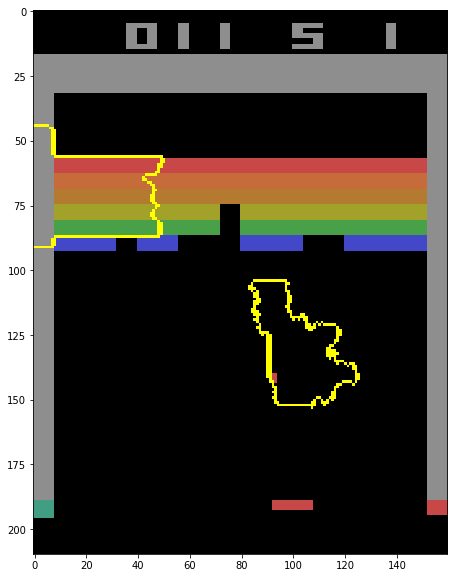

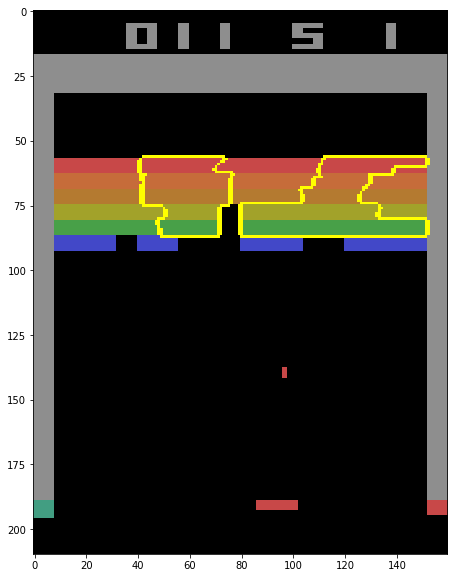

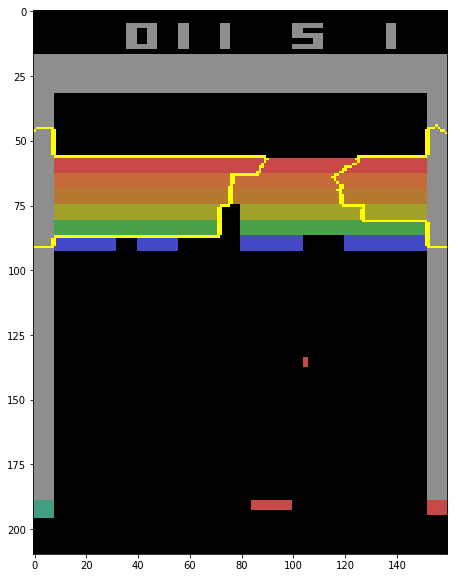

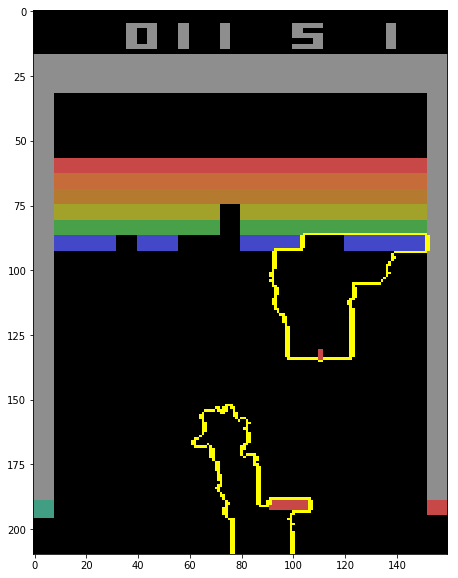

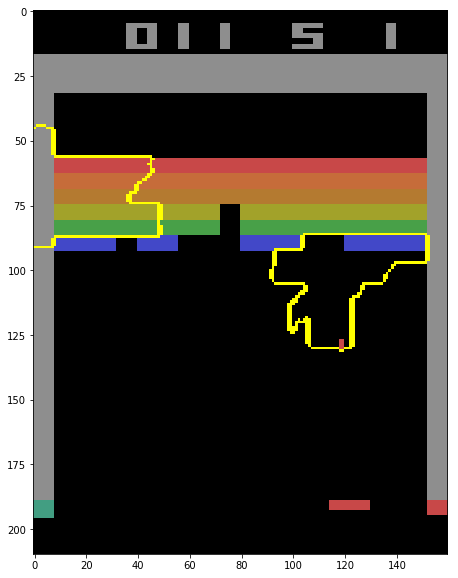

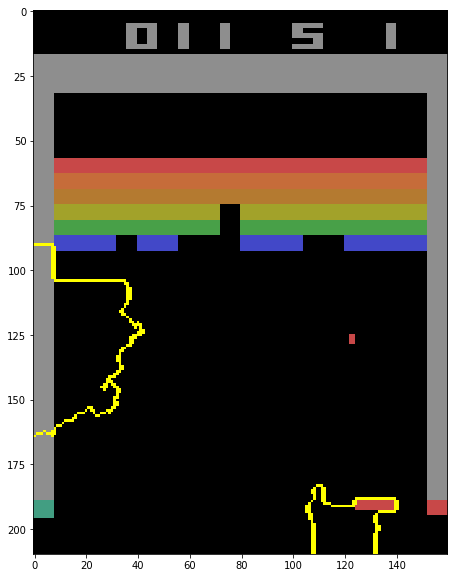

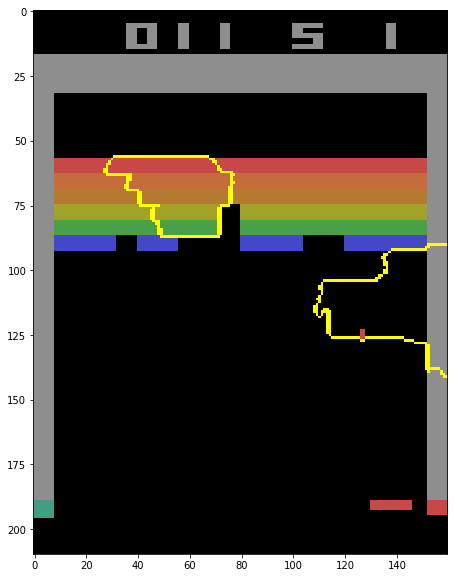

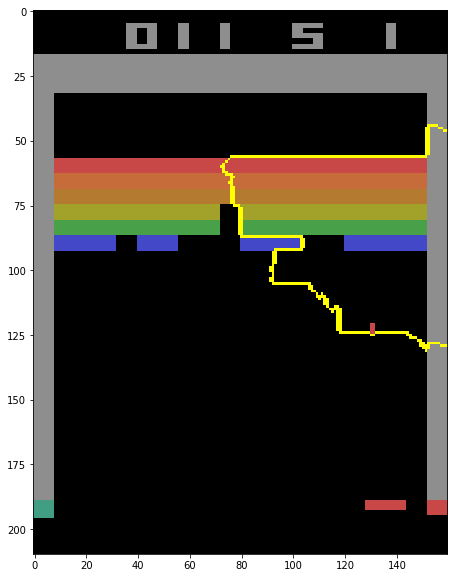

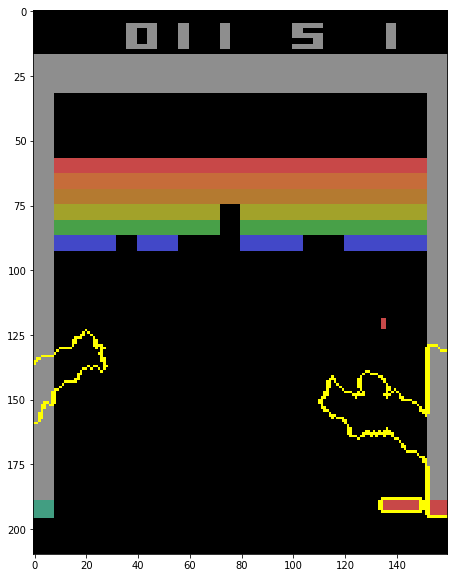

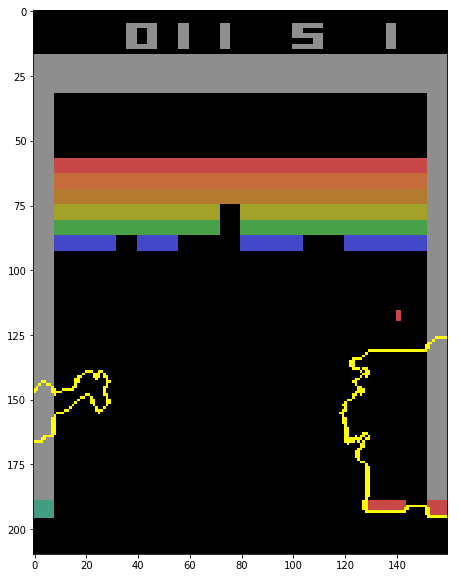

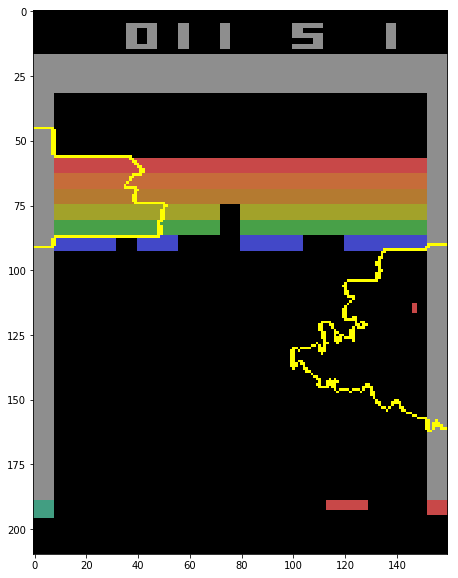

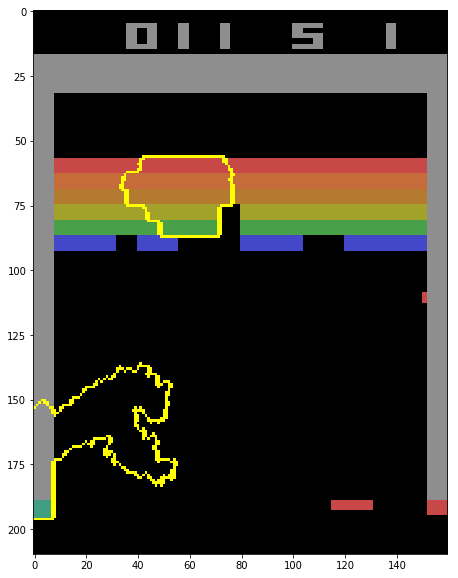

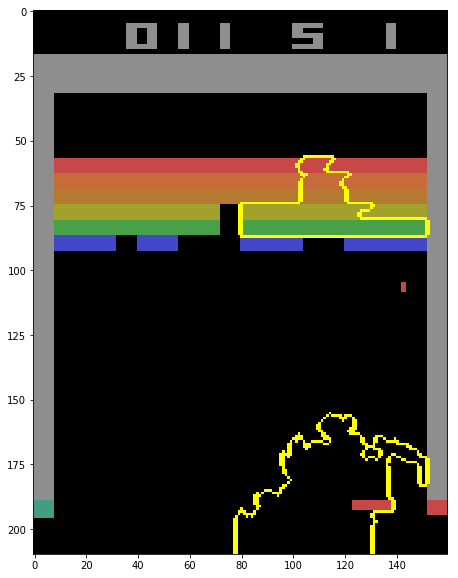

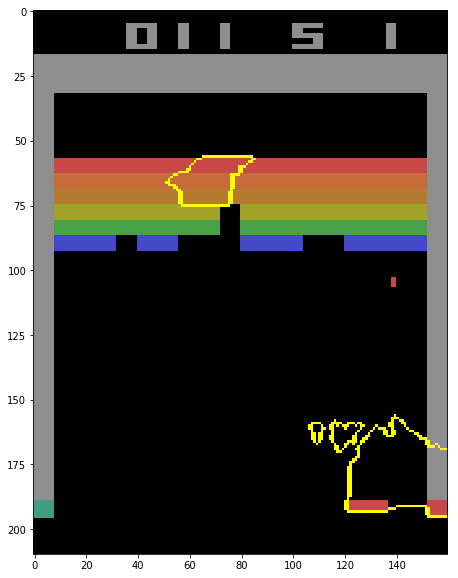

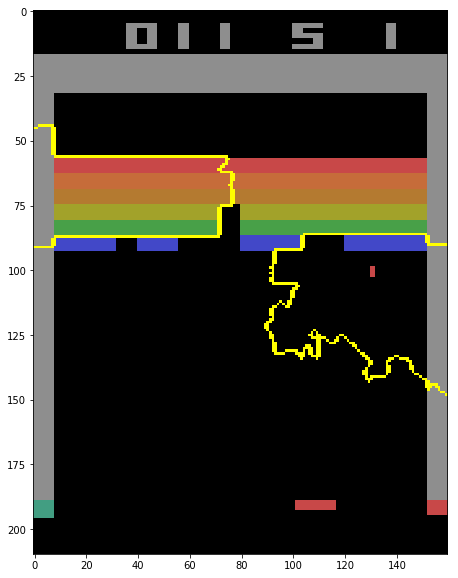

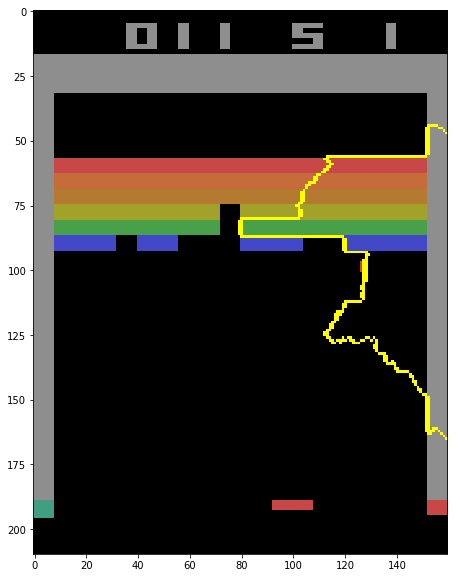

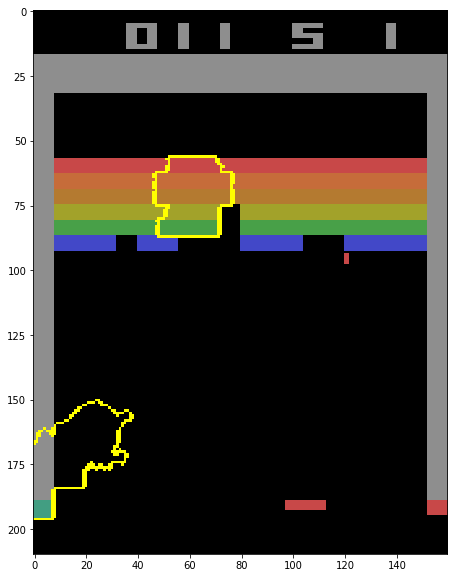

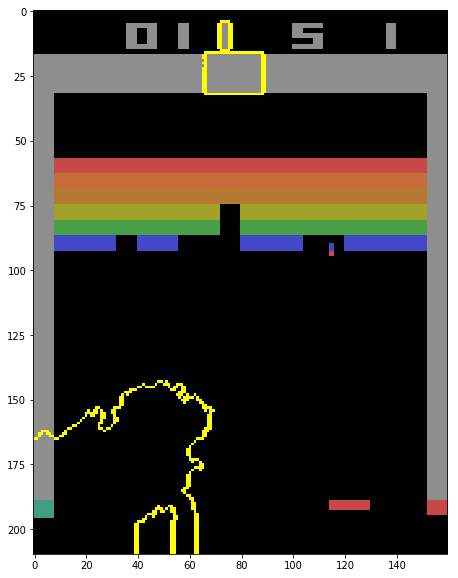

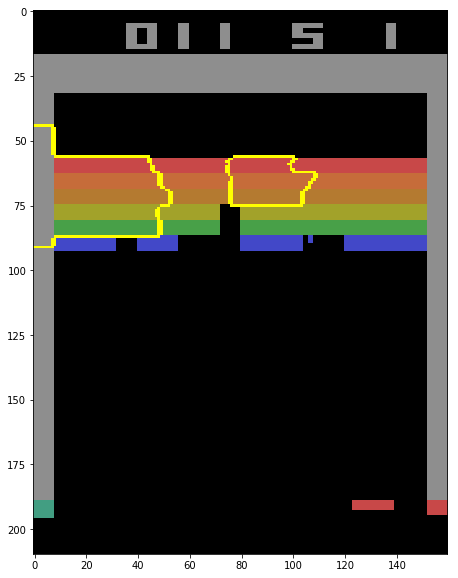

In [5]:
current_state = env.reset()
for i in tqdm(range(400)):
    x = np.expand_dims(current_state, axis=0)
    action = np.argmax(model.predict(x)[0])
    if i > 350:
        explanation = explainer.explain_instance(current_state, model.predict, top_labels=4, hide_color=0, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(action, positive_only=True, num_features=2, hide_rest=False)
        plt.figure(figsize=(10,10))
        plt.imshow(mark_boundaries(temp /255, mask))
    current_state, reward, done, _ = env.step(action)
    
    
    #env.render()